### Project 2: Classification and Model Evaluation
## Animal Shelter Outcomes: A Classification Problem
#### Alex Matsunami, RJ Smith, Cory Nichols

## Business Understanding


Millions of animal companions end up in shelters each year in the United States. These animals may be stray, rescued from a difficult situation or given up by their previous families. Each year, roughly 40 percent of all dogs and cats in shelters are euthanized. 

Our dataset comes from the Austin Animal Center in Austin, Texas and is part of a Kaggle competition. Using this data, we hope to find trends or rule sets identifying the outcomes of animals in shelters. The findings would subsequently drive shelter practices, hopefully for more social good than business good. For instance, if spaying or neutering a dog or cat is highly suggestive of a favorable outcome for an animal, shelters should implement policies ensuring all animals are fixed prior to adoption. This practice may cost the shelter more money, but would improve the welfare of the animal population. Further, could something as simple as giving each an animal a name drive a more favorable outcome? This particular practice would cost nothing but time and in turn improve the welfare of the animal population in cities. Cost savings, however, could be gained from our analysis. For instance, it may be easy enough to automate intake and processes for certain breeds or genders of animals while focusing attention on breeds or genders of animals that the data indicate "need more help."

We intend to use the 27 thousand records in the training set as a reference for other major cities in the United States, where most animal shelter practices are similar from an intake and outcome perspective. Our dataset includes statistics on breed, color, sex, and age from the Austin Animal Center.

Success should be categorized into analytical and business goals. Analytical goals would be based on classification accuracy on a sizeable test data set given by a confusin matrix where overall classification accuracy is greater than 85% at minimum with at least 85% precision. Further, and possibly more importantly, we hope our analysis drives at least a 20% decrease in animal euthanizations and transfers combined over a two calendar year period.  


## Data Meaning and Data Types

#### Overview

The original shelter outcomes dataset obtained from Kaggle.com contained the following ten attributes: Animal ID, Name, DateTime, OutcomeType, OutcomeSubtype, AnimalType, SexuponOutcome, AgeuponOutcome, Breed, and Color. The training dataset in use is 26,729 records while the test dataset contains roughly 12,000 records. We will be utilizing the training dataset. Each attribute in the training dataset is categorical, with AgeuponOutcome to be converted to continuous. 

#### Target Features: Adoption, Spayed/Neutered

Based on our work in Project 1, we have determined the outcome of interest with the most significnat business impact is **Adoption**.

While there are other outcomes of interest that have less business impact from Adoption (a primary objective for the animal shelter), we determined that a more interesting tool for learning would be to examine a primary explanatory variable of adoption: **Spaying and Neutering**.

Because these are relatively simple and cost-effective operations to perform and have such a profound impact on the animals lives, as well as their adoptability, we determined there is significant business impact and value in understanding the explanatory variables for this target feature. Additionally, we wish to determine if we can reliably predict whether an animal is fixed, given its adoption (and/or other) outcome(s).

#### Explanatory Features

**TODO**: Break this out into list of the dataset features. Then, determine what are the issues and data cleansing. Break out the missing features and imputation separately.

**============================**



The explanatory features in our dataset are made up of AnimalID, Name, DateTime, AnimalType, SexuponOutcome, AgeuponOutcome, Breed and Color. Perusing the data at a high level, we can easily see that there are many opportunities to split the data into valuable, new features which will help train our classification algorithm more effectively.

AnimalID is a unique identifier given to every animal that enters a shelter. For the purpose of statistical analysis, the Animal ID's or substring of the animal ID does not provide valuable information and will be removed from the dataset. 

Name is a nominal feature with 6374 different names represented in the dataset. This feature may be valuable from a classification standpoint: does a pet being named increase the chances of adoption? The most frequent animal name in our dataset is 'Max.'

DateTime is a temporal feature which denotes the time at which an outcome occurred. In particular, this attribute is useful from a data analysis standpoint only. For instance, do euthanizations occur at a particular point during the day? However, from a classification standpoint, we do not expect this feature to be valuable.

AnimalType is a nominal feature with two levels: Cat and Dog. This feature will likely be a critical feature for classification and data analysis.

SexuponOutcome is a nominal categorical feature with five levels: Neutered Male, Intact Male, Spayed Female, Intact Female, and Unknown. This attribute can easily be split into separate nominal features indcating if an animal is fixed and the gender of the animal. 

AgeuponOutcome is an ordinal feature with 44 levels, or different ages that were reported for animals upon outcome. In order to normalize this feature, we will attempt to convert AgeuponOutcome into days. Examples of levels in this feature include: 1 year, 15 days, 7 months. Each level begins with an integer in every case. The most frequent level is '1 year.'

Breed is a nominal categorical feature with 1380 levels that represent different breeds for both dogs and cats. Breed holds generic levels such as "domestic shorthair" for dogs, which may indicate an inability to truly determine the breed type. We will need to be cognizant of this fact when training our classification model. This feature holds many opportunities for simplification and feature creation and transformation. For instance, we can identify breeds with a 'reputation', size of the animal and popular breeds.

Finally, color is another nominal categorical feature with 366 level that represent the different combination colors of the animals entering the shelter. An example of a level of Color is "Brown/White," with the first color representing the primary color of the animal. Due to the number of levels in the Color feature, aggregation of the levels of color will be needed to effectively train our classification algorithm and derive business impact. 

## Data Preprocessing

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,Imputer
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
breedMap = pd.read_csv('breed_size.csv')
breedMap['Size'] = breedMap.Size.apply(lambda x: x.strip())


Our dataset is made up of 10 variables, many of which can be split or transformed into additional variables. Further, the majority of the variables are categorical: mostly nominal variables except for ordinal variables like Age and temporal variables like DateTime. Some variables, such as AnimalID, will provide no value in our analysis.

Our class feature or target feature is OutcomeType. We are interested in classifying animal outcome types given the other explanatory variables, which we will elaborate upon further. Let's take a look at a few objects to get our feet wet.


### Test/Training Split
There is test dataset for Kaggle, but no target labels on that set, so it is not useful for determining the scoring in our evaulation--only upon submission to Kaggle grader.

Thus, we break up prior to any downstream processing the test and training datasets. We will then be able to use the training set in model evaluation in the testing phase with the appropriate features intact.

In [3]:
df['is_test'] = (np.random.rand(len(df.index)) < 0.8)

### Age Cleanup and Imputation
In the data set, age is expressed in combination of year, week, month, or days. Thus, we will want to normalize this to days prior to imputing the missing values.

In [4]:
print df.AgeuponOutcome.head(5)

# First, replace the missing values with -1

df['AgeuponOutcome'] = ["-1 days"
                        if pd.isnull(i) else i for i in df['AgeuponOutcome'].values]

# Split out the numbers from the units
df['AgeValue'] = df['AgeuponOutcome'].apply(lambda x: x.rstrip('s').split())
            
ageMap = {'year': 365, 
          'week': 7, 
          'month': 30,
          'day': 1} 

# Apply the multiplication of the units
df['AgeValue'] = df['AgeValue'].apply(lambda x: ageMap.get(x[1])*int(x[0]))

nonMissing = df[df.AgeValue >= 0]

medianAge = nonMissing['AgeValue'].median()

# Impute the median value across the non-missing values and apply
df['AgeValue'] = [medianAge
                        if i == -1 else i for i in df['AgeValue'].values]

print df.AgeValue.head(5)

0     1 year
1     1 year
2    2 years
3    3 weeks
4    2 years
Name: AgeuponOutcome, dtype: object
0    365.0
1    365.0
2    730.0
3     21.0
4    730.0
Name: AgeValue, dtype: float64


### More Feature Imputation

Before we continue, it's critical our data is clean. This means imputation or dropping missing values and objects if necessary. As we have already imputed the age in processing the complex type with units above, the only other column we must imput is the SexuponOutcome feature, with only a single instance with missing data.

Of the other features missing values, we will drop the OutcomSubtype as it is missing far to often to be useful. However, the fact that animals are missing Names is in itself useful, and we will treat that separately later on.

**TODO** Move the has_name calculation up here and remove the original column as part of "imputation" section.

In [5]:
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n\n'


Number of nulls in the data set: 
AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome        0
Breed                 0
Color                 0
is_test               0
AgeValue              0
dtype: int64 





Based upon the information retrieved from the DataFrame, we are dealing with roughly 27 thousand records in the training set. We are only interested in the "OutcomeType" as our y (classifier) data. Outcome subtype is a sparse drill down on the Outcome type with sub-codes which are not explained thoroughly. Therefore, we recommend dropping this value as it is aub-variable of the outcome variable we are interested with roughly 50% valid values.

The good news is: 40% of animals are being adopted, most of which are neutered male dogs about a year old. 

In regard to new feature creation, we observe multiple opportunities. For instance, it will be interesting to see if having a name affects outcome and if the type of breed is aggressive (has a "reputation"). We can also see converting the AgeuponOutcome being valuable. 

However, before we create or transform features, let's clean up the data a bit more. There are a few nulls in our dataset. Of concern are the nulls in AgeuponOutcome and SexuponOutcome, in which there are 18 and 1 null values, respectively. This is not a large concern given the size of our dataset and what looks to be good quality data overall. However, we will attempt to keep the age nulls in the dataset. Losing one object in the dataset due a null in SexuponOutcome is not a concern. Because we care about whether or not a pet is named, the nulls in Name are not a concern. Further, OutcomeSubtype is simply a click down of OutcomeType, which is our classifier, and is quite sparse. We are dropping OutcomeSubtype, we are not concerned with the nulls.


In [6]:
del df['OutcomeSubtype'], df['AnimalID'] # drop extraneous data  columns
df = df.reset_index() # reset index to ensure further operations are executed correctly

# Impute the mode value across the non-missing values and apply.
# Built-in Imputer doesn't support categorical, so compute and apply the mode here.

nonMissingSex = df[~pd.isnull(df.SexuponOutcome) & (df.SexuponOutcome != "Unknown")]
modeSex = nonMissingSex['SexuponOutcome'].value_counts().idxmax()

df['SexuponOutcome'] = [modeSex
                        if pd.isnull(i) or i == "Unknown" else i for i in df['SexuponOutcome'].values]


### Has_Name Feature Engineering
The only remaining feature with missing values is the Name. Here, we transform this into more useful binary feature as to whether or not the animal had a name. The missing data is actually a key piece of information!

In [7]:
print 'There are %d unique names in the data set' % len(np.unique(df['Name'].values))

# 6375 unique names. That is quite a few names. Let's generalize into a binary feature called has_name instead:
# per Eric's feedback, use pandas functionality instead and do this more efficiently vs pure python list comps:

df['has_name'] = df['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)

# Now, remove the Name as we don't actually use this subsequently.
del df['Name']


There are 6375 unique names in the data set


C:\Anaconda2\lib\site-packages\numpy\lib\arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [8]:
del df['index']
print 'Number of nulls in the data set: \n', df.isnull().sum(),'\n'
df.head()

Number of nulls in the data set: 
DateTime          0
OutcomeType       0
AnimalType        0
SexuponOutcome    0
AgeuponOutcome    0
Breed             0
Color             0
is_test           0
AgeValue          0
has_name          0
dtype: int64 



,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,is_test,AgeValue,has_name
0,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,365.0,1
1,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,False,365.0,1
2,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,730.0,1
3,2014-07-11 19:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,True,21.0,0
4,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,True,730.0,0


## Data Creation and Transformation


All columns outside of the name column have been dropped or imputed and are now non-null.

Let's create some useful variables in our data set. It would be interesting to investigate whether or not a potential adoptee having a name has an effect on their outcome.

The gender and what we will call "is_intact" (whether an animal is intact (not fixed)) are also interesting variables to investigate.

Further, it would be better to represent age as a continuous ratio variable. We will transform age into day and check it's distribution for normality.


In [9]:
# Further, let's split out the intactness of an animal: whether or not the animal has been spayed or neutered
# as well as the gender:

intactness = lambda x: 'Fixed' if x.split()[0] in ['Spayed','Neutered'] else 'Intact'
df['is_fixed'] = df['SexuponOutcome'].apply(intactness)

df['gender'] = df['SexuponOutcome'].apply(lambda x: x.split()[1])

df['SexuponOutcome']


0        Neutered Male
1        Spayed Female
2        Neutered Male
3          Intact Male
4        Neutered Male
5        Intact Female
6          Intact Male
7        Neutered Male
8        Spayed Female
9        Spayed Female
10       Neutered Male
11       Spayed Female
12       Neutered Male
13       Neutered Male
14       Neutered Male
15       Neutered Male
16         Intact Male
17       Intact Female
18       Intact Female
19       Neutered Male
20         Intact Male
21       Spayed Female
22       Spayed Female
23       Neutered Male
24       Neutered Male
25       Intact Female
26       Spayed Female
27       Spayed Female
28       Spayed Female
29       Neutered Male
             ...      
26699    Neutered Male
26700      Intact Male
26701    Intact Female
26702    Spayed Female
26703    Neutered Male
26704    Intact Female
26705    Intact Female
26706    Spayed Female
26707    Neutered Male
26708    Neutered Male
26709    Spayed Female
26710    Intact Female
26711    In


Let us also identify potentially 'aggressive' breeds using a bit of regex and top 10 aggressive breeds list: 
http://www.therichest.com/rich-list/the-biggest/the-worlds-10-most-dangerous-dog-breeds/?view=all

We will create a binary feature 'is_aggressive.' If the dog's breed is contained in the aggressive breed list, is_aggressive will be 1, else it will be 0.  


In [10]:
import re

agg_breeds = ['Bull','Doberman','Rottweiler','Husky','German','Boxer','Malamute','Dane']

df['is_aggressive'] = [re.split('\W+',i) for i in df['Breed']]

for idx, i in enumerate(df['is_aggressive'].values):
    if len(agg_breeds) != len(set(agg_breeds).difference(i)):
        df.set_value(idx, 'is_aggressive', 1)
    else:
        df.set_value(idx, 'is_aggressive', 0)      


Let's also grab the primary color using same regex approach and reduce the number of categories in color. We will map the primary color (the first color listed) to a colorMap dictionary.


In [11]:
colorMap = {'exotic':['Agouti','Calico','Lynx','Tricolor','Tortie','Flame','Torbie'], # these are some odd colors...
            'dark':['Black','Chocolate','Liver','Sable','Seal','Red'],
            'neutral':['Gray','Silver','Tan','Buff','Brown','Fawn'],
            'light':['Cream','Blue','Pink','White','Yellow','Lilac','Ruddy','Apricot','Orange','Gold']}

# use pandas built ins to munge the data a bit faster - use rename, split_interval to convert age
df['primary_color'] = [re.split('\W+',i)[0] for i in df['Color']]

for idx, color in enumerate(df['primary_color'].values):
    for k,v in colorMap.items():
        if color in v:
            df.set_value(idx,'primary_color', k)

One other critical attribute we are missing is animal size. We assume the size of an animal is extremely important, especially when it comes to adopting dogs. Therefore, we have retrieved the American Kennel Club's (http://www.akc.org/dog-breeds/) listing of breeds and associated sizes. Because there are so few toy breeds listed, we combined toy and small into "small." For breeds that were not represented in AKC's list (there were about 20), each  was mapped to size buckets based on the following logic: Small (avg weight <= 20 lbs ), Medium (<= 65 lbs), Large (<= 100 lbs), Giant (> 100 lbs). All cats were mapped to "small." We expect the size feature to be more relevant for dogs, and we expect it to be significant. We've also added in an indicator for the top 10 most popular dogs.

In [12]:
# set primary breed as the lookup
df['BreedLU'] = [i.rstrip('Mix').split('/')[0].strip() for i in df['Breed']] 

# zip up breed and size into a dict
sizeMapper = dict(zip(breedMap['Breed'], breedMap['Size'])) 

# map it, I love Pandas
df['size'] = df['BreedLU'].map(sizeMapper) 
df['size'] = np.where(df['AnimalType'].values == 'Cat', 'Small', df['size']) # set cats to small (unless Garfield)
del df['BreedLU'] # drop the lookup vector

In [13]:
# Source: http://www.petinsurance.com/healthzone/pet-articles/pet-breeds/Top-10-Dog-Breeds.aspx
topBreeds = ['Boxer', 'Rottweiler', 'Poodle', 'Yorkshire Terrier',
                'French Bulldog', 'Beagle', 'Bulldog',
                'Golden Retriever', 'German Shepherd', 'Labrador Retriever']

topBreedList = []
for i in df['Breed']:
    matched = False
    for topBreed in topBreeds:
        if topBreed in i:
            topBreedList.append(1)
            matched = True
            break
    if not matched:
        topBreedList.append(0)       

df['is_popular'] = topBreedList

In [14]:
from datetime import datetime
# let's also account for the time of day these actions happen as well as the day of the week
df['DateTime'] = df['DateTime'].astype(np.datetime64)

df['is_Weekday'] = df['DateTime'].apply(lambda x: 1 if datetime.weekday(x) < 5 else 0)

df['time_of_day'] = pd.cut(df.DateTime.dt.hour,[-1,11,17,1e6], 4, labels = [0,1,2])
df['time_of_day'] = df.time_of_day.astype(np.int64)
df['hour'] = df.DateTime.dt.hour
# morning, afternoon, evening

# Now, remove the DateTime, as we have engineered the necessary features

del df['DateTime']

## Feature Engineering

First, let's convert categorical features to objects and make column names a little easier to follow:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 18 columns):
OutcomeType       26729 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26729 non-null object
AgeuponOutcome    26729 non-null object
Breed             26729 non-null object
Color             26729 non-null object
is_test           26729 non-null bool
AgeValue          26729 non-null float64
has_name          26729 non-null int64
is_fixed          26729 non-null object
gender            26729 non-null object
is_aggressive     26729 non-null object
primary_color     26729 non-null object
size              26729 non-null object
is_popular        26729 non-null int64
is_Weekday        26729 non-null int64
time_of_day       26729 non-null int64
hour              26729 non-null int64
dtypes: bool(1), float64(1), int64(5), object(11)
memory usage: 3.5+ MB


In [16]:
df.columns = ['Outcome','Type','SexuponOutcome','AgeuponOutcome','Breed','Color', 'Is_Test', 'Age_Value',
              'Has_Name','Is_Fixed','Gender','Is_Aggressive','Primary_Color','Size', 'Is_Popular','Is_Weekday'
              ,'time_of_day','hour']

categ = ['Type','Breed','Is_Fixed','Gender','Is_Aggressive', 'Primary_Color', 'Size','Has_Name',
       'Outcome','Is_Popular', 'Is_Weekday','time_of_day']

df[categ] = df[categ].astype(np.object)

The data is starting to tell more of a story with our transformed dataset. There are no longer nulls and it looks as if mostly small dogs with names make up a good portion the data set. Nearly 70% of animals in our dataset are fixed. Interestingly, domestic shorthair mixes dominate the data set from a breed perspective, which have 1380 unique values. This may be a "catch all" breed used to identify dogs the shelter had trouble identifying and may be a future issue from a classification standpoint.

We also transformed the age variable into a continuous feature. Let's ensure it has a valid data type and quickly take a look at its distribution and some other key statistics.

# Feature Visualization

Here, we will refer the reader to the prior work on the extensive visualization done in Project 1.

However, here, we will want to simply break out the features as is done here. Also, we will want to show the target features, and break these out in a way that makes sense (bar or pie chart)

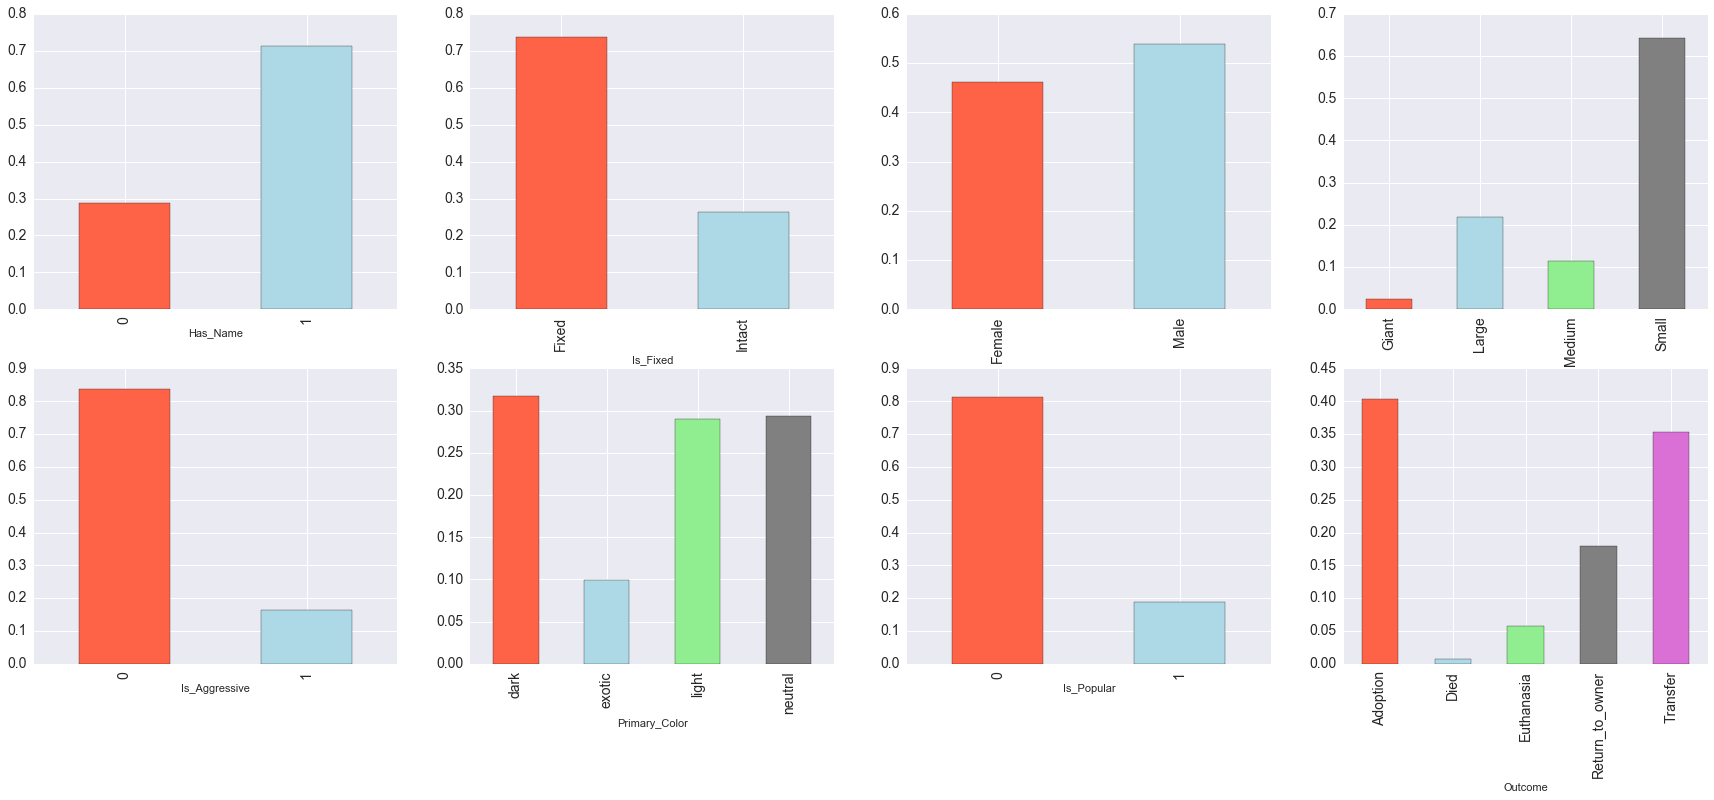

In [17]:
import matplotlib

#####
# Removing age_range from the visualization here
#####

features = ['Has_Name','Is_Fixed','Gender','Size','Is_Aggressive','Primary_Color', 'Is_Popular','Outcome']

plt.figure(figsize=(30,18))
for index, feature in enumerate(features):
    plt.subplot(3, 4, index +1)
    groups = df.groupby(feature)['Outcome'].count()/len(df)
    ax = groups.plot(kind = 'bar', color =['tomato','lightblue','lightgreen','gray','orchid'], fontsize=14)

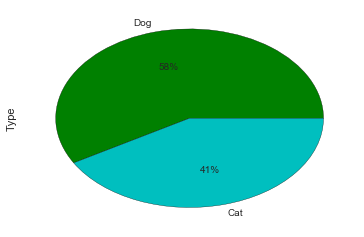

In [18]:
df.Type.value_counts().plot(kind='pie', autopct='%1d%%', colors = ['g', 'c'])

Some interesting discoveries come out of simple percentages: for instance, most animals being adopted are small. This is likely because cats are also categorized into the small category -- we will explore animal type crosstabs more thoroughly. Most critically, adoption rates show promise: 40 percent of all animals are adopted. Our business partners are looking to increase this number. Further, given Austin's policy of no euthanizations unless aggressive or sick, it's easy to see that most animals do indeed survive, however, most are transferred to other shelters. Transfers come with high cost for our business partners. This is likely a metric they'd like to reduce. The more an animal is passed through the system, the larger emotional detriment and the higher cost for the shelters in managing input/output as well as standard medical treatment, room and board and surgical operations. Further, it looks as though the most popular breeds are not present in the sample of shelter animals, which could be a bad sign for future adoptability.

Based on these charts, we also likely can combine size into a three level factor feature by combining giant into large since it is about 2% of the dataset. Further, most animals are dark colored and fixed. Fixed animals make up almost 75% of the dataset while dark colored animals are 40% of the sample size.

Further, there are more dogs than cats in our dataset. This is actually a surprise, given that stray cats are far more frequently encountered than stray dogs. 

### Additional Work: Algorithmic Setup and Numeric Conversions

To make things a bit easier to visualize in seaborn and also set up our data for classification algorithms, let's go ahead and set up dummies and remap some of our categorical variables to integers where appropriate.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 18 columns):
Outcome           26729 non-null object
Type              26729 non-null object
SexuponOutcome    26729 non-null object
AgeuponOutcome    26729 non-null object
Breed             26729 non-null object
Color             26729 non-null object
Is_Test           26729 non-null bool
Age_Value         26729 non-null float64
Has_Name          26729 non-null object
Is_Fixed          26729 non-null object
Gender            26729 non-null object
Is_Aggressive     26729 non-null object
Primary_Color     26729 non-null object
Size              26729 non-null object
Is_Popular        26729 non-null object
Is_Weekday        26729 non-null object
time_of_day       26729 non-null object
hour              26729 non-null int64
dtypes: bool(1), float64(1), int64(1), object(15)
memory usage: 3.5+ MB


In [20]:
# size is ordinal, lets create a dict and map it
sizeMap = {'Giant':4,'Large':3,'Medium':2,'Small':1}
df['Size'] = df['Size'].map(sizeMap)

# grab dummies for our nominal variables
df = df.join(pd.get_dummies(df['Primary_Color']))

# relabel our outcomes
classLabels = LabelEncoder()
df['Outcome_Label'] = classLabels.fit_transform(df['Outcome']) 
df['Primary_Color_Label'] = classLabels.fit_transform(df['Primary_Color']) 

Now, let's take a look at more relationships between our explanatory features. Specifically the age_value, size and intactness of dogs:

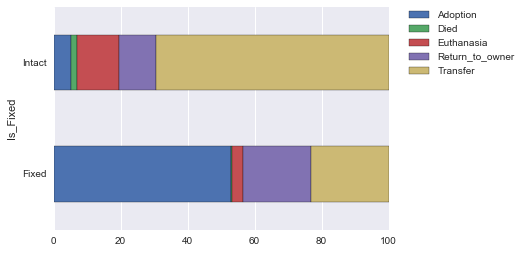

In [21]:
animals = pd.crosstab(df['Is_Fixed'], df['Outcome'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Probably the most significant finding thus far: it looks as if over 50 percent of fixed animals are adopted. Specifically, looking at the second chart, over 90 percent of adopted animals are fixed. Given the moderate association found for Is_Intact, this is a critical datapoint discovered for our classification purposes going forward. Further, the majority of animals that perished were intact. This could be due to pre-existing conditions coming into the facility.

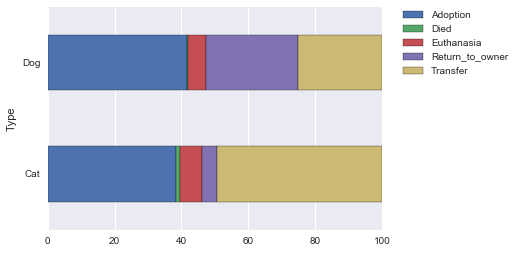

In [22]:
animals = pd.crosstab(df['Type'], df['Outcome'])
rate = animals.div(animals.sum(1).astype(float), axis=0)*100
rate.plot(kind='barh',stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Cats are transferred far more often than dogs, however, both are adopted at similar rate. Dogs are much more likely to be returned to their owners than cats. Of interest is the deaths among cats and dogs: only cats have died in our dataset. Thankfully both cats and dogs do not die or are not euthanized often. 

# Mini-Lab Start : Logistic Regression and Support Vector Machines

Based on exploratory data analysis, some initial conclusions were made: we could easily see that fixing animals has a significant effect on their ability to be adopted, simply by visualizing the data and running basic statistical tests. 

However, we figured we were missing a few variables. In particular, the time of the outcome. Understanding when outcomes happen could be a critical component in understanding what optimal times or days our business partners should stay open or promote adoptive benefits heavily. 

Further, in order to answer the question more succintly, we have reduced our problem to a binary one: adopted or not. Given a binary outcome, there is roughly a 45/55 split on adopted and not adopted outcomes, respectively. 

A binary outcome will help to explain classification models more effectively and answer our business partner's question more directly: what variables are the most important for ADOPTION?


The first thing we need to do is get our data into algorithmic shape. We intend to use two methodologies to build a classification model predicting binary outcomes. These two methodologies are Logistic Regression and Support Vector Machines.

Given the linear separation dependency of Logistic Regression, we find it critical to attempt a non-linear classification algorithm with a Support Vector Machine. We will also fit a linear SVM to the data as well.

This should help us to not only fit a predictive model, but to also create a description for the answer to our the question: "How can we get more animals adopted?"

Let's go ahead and clean our data up. We have quite a few features left over, simply for visualization purposes.

In [23]:
df.head()

,Outcome,Type,SexuponOutcome,AgeuponOutcome,Breed,Color,Is_Test,Age_Value,Has_Name,Is_Fixed,...,Is_Popular,Is_Weekday,time_of_day,hour,dark,exotic,light,neutral,Outcome_Label,Primary_Color_Label
0,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,True,365.0,1,Fixed,...,0,1,0,2,0.0,0.0,0.0,1.0,3,3
1,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,False,365.0,1,Fixed,...,0,0,2,19,0.0,0.0,1.0,0.0,2,2
2,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,True,730.0,1,Fixed,...,0,0,2,20,0.0,0.0,1.0,0.0,0,2
3,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,True,21.0,0,Intact,...,0,0,0,2,0.0,0.0,1.0,0.0,4,2
4,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,True,730.0,0,Fixed,...,1,1,2,20,0.0,0.0,0.0,1.0,4,3


We'll create a new dataframe called df_alg (for df_algorithm), and discretize our mostly categorical dataset. 

We've also included our new time features for good measure: time_of_day, is_weekday, and hour. These variables are ordinal, binary and continuous in nature, they do not require dummies and the range on hour is 24. 

In [24]:
for c in np.unique(df['Outcome']):
    print c, df.Outcome[df.Outcome == c].count()

# given such a low representation for died and euthanasia, it would be better to make this a binary outcome
# we will group all other values except adoption

# grab a new dataframe
df_alg = df[['Is_Fixed','Has_Name','Type','Is_Aggressive','Size','Is_Popular','Age_Value',
             'Gender','dark','exotic','light','neutral','Is_Weekday','time_of_day','hour','Outcome_Label']]

df_alg.loc[:,'Outcome_Label'] = df.loc[:,'Outcome'].apply(lambda x: 1 if x == 'Adoption' else 0)
df_alg.loc[:,'Is_Fixed'] = df.loc[:,'Is_Fixed'].apply(lambda x: 1 if x == 'Fixed' else 0)

# now let's line up the rest of our features to get ready for logistic regression and SVM
df_alg.loc[:,'Type'] = df.loc[:,'Type'].apply(lambda x: 1 if x == 'Dog' else 0)
df_alg.loc[:,'Gender'] = df.loc[:,'Gender'].apply(lambda x: 1 if x == 'Male' else 0)

#####
#df_alg.loc[:,'age_range'] = classLabels.fit_transform(df.loc[:,'age_range'])
#####

df_alg.loc[:,'Size'] = classLabels.fit_transform(df.loc[:,'Size'])

df_alg = df_alg.astype(np.int64)


Adoption 10769
Died 197
Euthanasia 1555
Return_to_owner 4786
Transfer 9422


C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## LOGISTIC REGRESSION

Now that we have a binary outcome we're interested in, we'll go ahead and fit a logistic regression model to the full feature set we just created and perform model selection on the data. (this is assuming we don't create a validation set from our training data as we haven't gotten there yet on lesson plan). 

However, in order to test effectively and ensure class balances in each split, we will use StratifiedShuffleSplit from sklearn. 

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

scl = StandardScaler()
lr = LogisticRegression()
X_train = df_alg.values[:,:-1] # features
y_train = df_alg.values[:,-1] # target, binary

cv_object =  StratifiedShuffleSplit(y=y_train,
                                    n_iter=5,
                                    test_size=0.2)


Since we have included an hour feature, it would be best to scale our data. Hour's range is 24, while the second largest range is 3, for age_range. Thus we will standardize our data appropriately to represent weights correctly and help us choose which variables are the most important in our model. Unfortunately, we cannot reduce dimensionality in this case with standard methods like PCA and LDA because of such a categorical heavy dataset.

Let's take a quick look at our accuracy on 3 shuffles with standardized data using an out of the box logistic regression model:

In [26]:
accuracies = cross_val_score(lr, scl.fit_transform(X_train), y=y_train, cv=cv_object, verbose= 0) # this also can help with parallelism
print(accuracies)

[ 0.73699963  0.73868313  0.7345679   0.73699963  0.73063973]


Let's also check out our accuracy across penalty and cost parameters:

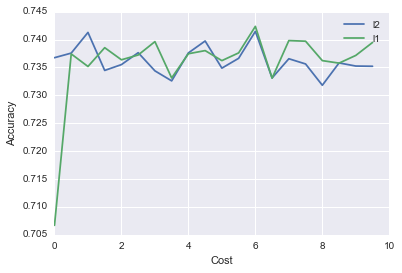

In [27]:
costs = np.arange(0.001,10,0.5)

l2s = []
l1s = []
for i in costs:
    for j in ['l1','l2']:
        lr2 = LogisticRegression(penalty = j, C = i)
        accuracies = np.average(cross_val_score(lr2, scl.fit_transform(X_train), y=y_train, cv=cv_object, verbose= 0))
        if j == 'l1':
            l1s.append(accuracies)
        else:
            l2s.append(accuracies)
# best accuracy @ cost of zero (max reg for logit) using l2 regularlization
plt.plot(costs, l2s)
plt.plot(costs, l1s)
plt.legend(['l2','l1'])
plt.ylabel('Accuracy')
plt.xlabel('Cost')
plt.show()

74% on our training set is not great, but it's better than random selection. That being said, we can definitely tune our model to understand how regularlization can help (or hinder) or classification accuracy. It looks as if L1 (LASSO) penalty is our optimal parameter setting for our training set. This will give us sparseness in our parameters, allowing us to simplify our model moreso than L2 (ridge). However, we need to first use our validation set to confirm our findings. 

First, let's take a look at our accuracy rate again, this time using five fold stratified cross validation and the number of observations in our data set. Let's look at our learning curve and the variability associated with our training and validation sets:

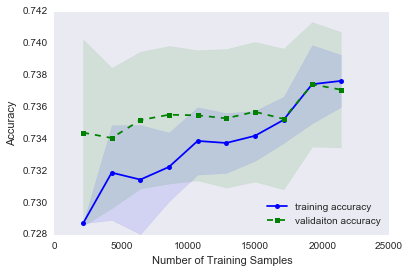

In [28]:
# playing with pipelines, adapted from Rauschka
from sklearn.learning_curve import learning_curve # uses stratified k fold by default

pipe_lr = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(penalty='l1'))]) # set up pipeline
                                                                                          # automatically scale
train_sizes, train_scores, valid_scores = learning_curve(estimator=pipe_lr, 
                                                         X = X_train, 
                                                         y = y_train, 
                                                         train_sizes = np.linspace(0.1, 1.0, 10) ,# spacing of samples, 
                                                         cv = 5, # 5 fold
                                                         n_jobs = -1) # use all processors
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.plot(train_sizes, train_mean, c='blue', marker='o',  markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, valid_mean, c='green', marker='s', linestyle='--',  markersize=5, label='validaiton accuracy')
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1, color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

What we can see is that we do not generalize well to our validation set in our training data when the number of samples is low -- we see high variance and overfitting. Validation lags behind training accuracy on average until about 21,000 samples. There is better generalization with a larger number of samples. As expected, the validation result does have a higher variance in this case, but in general, more samples benefits the accuracy of our model. 

Let's tune the critical hyperparameters of our Logistic Regression model: regularlization cost and penalty. We'll interactively test the parameters below and then visualize optimal cost and penalties for our dataset.

In [29]:
from ipywidgets import widgets as wd
from sklearn.metrics import roc_curve

def lr_explore(cost, penalty):
    lr = LogisticRegression(penalty=penalty, C=cost, class_weight=None) 
    accuracies = cross_val_score(lr, scl.fit_transform(X_train), y_train, cv=cv_object) 
    print 'Average Accuracy:', np.average(accuracies)
    
wd.interact(lr_explore, cost=(0.001,10.0,0.05), penalty =['l1','l2'])

Average Accuracy: 0.738309016087


<function __main__.lr_explore>

After confirming l1 penalty with a large amount of regularlization is optimal for fitting our model let's take a look directly at a visual of our regularlization parameter C:

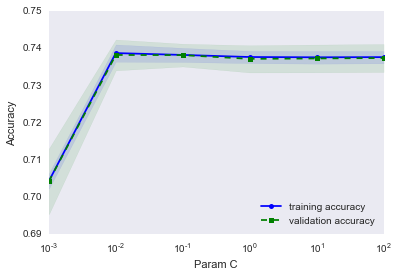

In [30]:
# take a look at C levels and associated accuracy on a stratified 5 fold CV
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, valid_scores = validation_curve(
                                             estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__C', # vary the C parameter directly
                                             param_range = param_range,
                                             cv = 5
                                             )
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.1, color='blue')
plt.plot(param_range, valid_mean, color='green', marker='s', linestyle='--', markersize=5,label='validation accuracy')
plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha = 0.1, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Param C')
plt.ylabel('Accuracy')
plt.show()

                                    

With a large amount of regularlization, we can see that our validation and training sets are almost identical. This indicates we are NOT overfitting our model with a significant C hyperparameter using LASSO (l1 penalty). Therefore, it's optimal we move forward with l1 and a significant regularlization. 

Note: sklearn's C parameter is an INVERSE regularlization parameter for logistic regression, the lower, the MORE regularlization in the model.

Now, let's repeat our 80/20 split on our training set using shuffles to see if we've improved based on our research.

In [31]:
lr_final = LogisticRegression(penalty='l1', C=0.001)
accuracies = cross_val_score(lr_final, scl.fit_transform(X_train), y_train, cv=cv_object) 
print np.average(accuracies)

0.705836139169


A very slight, however, an improvement! Now that we've performed model selection on our training set by dividing it into subtraining and validation sets, let's fit the entire training set and take a look at our coefficients.

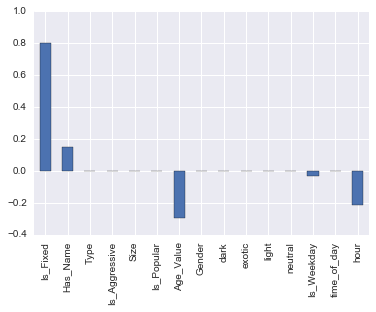

In [32]:
lr_final.fit(scl.fit_transform(X_train),y_train)
weights = pd.Series(lr_final.coef_[0], index=df_alg.columns[:-1])
weights.plot(kind='bar')
plt.show()
# LASSO results show we can eliminate pretty much everything outside of is_fixed and age_range (woot)

## Interpreting Logistic Regression Weights

Even though our model is only around 74% accurate on our validation dataset, we have obvious opportunities to simplify. The standardized data has resulted in a sparse coefficient array for our Logistic Regression model. This is one of the main benefits of utilizing a LASSO approach. 

Is_Fixed (0.91) is obviously the most important attribute in determining whether or not an animal is adopted. If an animal is fixed, it's more likely to be adopted. Age (-.36), as well, is quite important. The younger, the more likely to be adopted.

These variables, from experience and domain knowledge, were expected to be highly important. Spaying and neutering is cost prohibitive for some consumers, and the average adoptor is almost always interested in younger animals. Further, most owners do no want animals who are capable of reporoducing. Age is important because of potential health risks and maximum anticipated time with the animal. However, these assumptions are purely anecdotal and would need to be tested themselves. That being said, the ultimate conclusion given the result above is not surprising. 

What is interesting, however, is the lack of importance when it comes to size. This could be a result of the binarization process, in which size categories were created and may need to be revisited. 

The business result confirms our initial suspicions: fix the animals, name them and make them available on the weekend to maximize the chance of adoption. Our business partners cannot do anything about age.

The analytical result allows us to move forward with a two feature model, including age_range and Is_Fixed. 

## Logistic Regression Conclusion

74% accuracy is better than random chance, however, our classification model can likely be improved by gathering critical features, such as pre-existing medical conditions, if the animal has reproduced before and solidifying whether or not an animal truly is aggressive, instead of using arbitrary lists to identify aggressive breeds. We believe this would push our model accuracy over 80% and provide a more holistic conclusion on what factors drive adoption for our business partners.

In [33]:
# extra, playing with ROC
'''
from sklearn.metrics import roc_curve, auc, accuracy_score # check area under curve score for ROC

false_positive_rate, true_positive_rate, thresholds = roc_curve(y, lr.predict(scl.fit_transform(X)))
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate,'b',
label='Area Under Curve = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1]), plt.ylim([-0.1,1.1])
plt.ylabel('TPR'), plt.xlabel('FPR'), plt.title('ROC Curve')
plt.show()
'''

"\nfrom sklearn.metrics import roc_curve, auc, accuracy_score # check area under curve score for ROC\n\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y, lr.predict(scl.fit_transform(X)))\nroc_auc = auc(false_positive_rate, true_positive_rate)\nplt.plot(false_positive_rate, true_positive_rate,'b',\nlabel='Area Under Curve = %0.2f'% roc_auc)\nplt.legend(loc='lower right')\nplt.plot([0,1],[0,1],'r--')\nplt.xlim([-0.1,1.1]), plt.ylim([-0.1,1.1])\nplt.ylabel('TPR'), plt.xlabel('FPR'), plt.title('ROC Curve')\nplt.show()\n"

## Support Vector Machine

Now let's take another route: support vector machines. We will fit both linear and non-linear support vector machines to the data and compare this methodology with logistic regression.

Based on tested performance, we will use sklearn's SGD classifier to perform a stochastic SVM and avoid memory and run time issues previously experienced.

### Using SVM Linear Kernel
We will use linear support vector which should give similar results to logistic regression as we are classifying on a binary class outcome.

Running the training only once, with 80% of data for training, and 20% of data for testing.

With SVM linear kernel, the computing performance of the model is sub-par, taking several minutes to run.
This is a common issue with support vector machines: potential additional accuracy and outlier resistance comes at a cost of more computing time. SVMs are less sensitive to outliers when compared to Logistic Regression, however, SVMs take longer to fit and longer to validate.

Logistic Regression is always preferred from a timing standpoint for well behaved datasets, such as streaming or event based data. Logistic Regression can be updated more easily and more timely. However, when datasets are non-linear, we need to relax linear assumptions. In these cases, kernel SVM accuracy is superior most of the time.

That being said, we have options in sklearn, using a stochastic implementation of SVM called SGDClassifier. Let's take this module for a spin and perform model selection.

In [34]:
# SVC will take some time. Use stochasitc gradient descent instead
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

scl = preprocessing.StandardScaler()

test_cases = int(len(df_alg.index) * 0.2)

x_train = df_alg.values[:-test_cases,:-1] # features
x_test = df_alg.values[-test_cases:,:-1] # features
y_train = df_alg.values[:-test_cases,-1] # target, binary
y_test = df_alg.values[-test_cases:,-1] # target, binary

model = SGDClassifier(loss='hinge', penalty='l2',n_jobs = -1, n_iter=1000)
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.744995322732


### Feature Weights
With Linear Kernel, we are able to leverage coefficients of the support vector to determine the relative weights of the explanatory variables. Here, we plot out the relative weights of each of the features used in training the model.

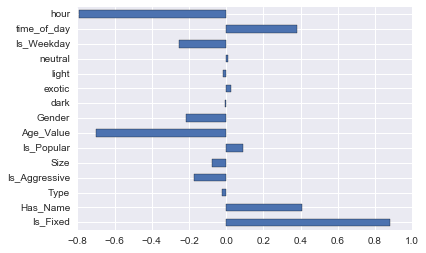

In [35]:
weights = pd.Series(model.coef_[0], index=df_alg.columns[:-1])
weights.plot(kind='barh')
plt.show()

Support Vector Insights
As in logistic regression, the same same features were chosen by the support vector as more significant in the SVM model trained from the data.
In particular, whether or not the animal is fixed has the most significance in terms of adoption potential, followed by the age of the animal, if it has a name, and then whether the breed is aggressive.
The hour, time of day, and whether or not the animal was brought in on the weekend also have significant impact on the adoptability of the animal, though not attributes of the animal, per se.

### Using SVM RBF Kernel

Now, we will use the Radial Basis Function Kernel to seek improvement here on model accuracy over the strict linear kernel.

In [36]:
from sklearn import svm

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.764826941066


### Separate Models: Cats vs. Dogs
Rather than incorporating only as a feature in a single model, let's break up the datasets into cats and dogs and then build separate models and compare the accuracies of each.

In [37]:
# df.loc[:,'Type'].apply(lambda x: 1 if x == 'Dog' else 0)
dogs = df_alg[df_alg.Type == 1]
cats = df_alg[df_alg.Type == 0]

print np.shape(dogs) #11134
print np.shape(cats) #15594

(15595, 16)
(11134, 16)


### Dogs

Now, let's train RBF kernel SVM for Dogs only and determine the accuracy.

In [38]:
x = dogs.values[:,:-1] # features
y = dogs.values[:,-1] # target, binary

test_cases = int(len(dogs.index) * 0.2)

x_train = dogs.values[:-test_cases,:-1] # features
x_test = dogs.values[-test_cases:,:-1] # features
y_train = dogs.values[:-test_cases,-1] # target, binary
y_test = dogs.values[-test_cases:,-1] # target, binary

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.722988137223


The lower accuracy score for dogs indicates there is additional work here to bring the model to parity to that of cats.

### Cats

Now, let's train RBF kernel SVM for Cats only and determine the accuracy.

In [39]:
x = cats.values[:,:-1] # features
y = cats.values[:,-1] # target, binary

test_cases = int(len(dogs.index) * 0.2)

x_train = cats.values[:-test_cases,:-1] # features
x_test = cats.values[-test_cases:,:-1] # features
y_train = cats.values[:-test_cases,-1] # target, binary
y_test = cats.values[-test_cases:,-1] # target, binary

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.820134658544


The accuracy of predicting adoption outcome of cats with 82% accuracy is quite good.

## Cross-Fold Validation Curves

Even with a stoachastic approach, as shown below, we are getting better performance and less overfitting. The l2 norm penalty looks to be the most optimal, with roughly 75% accuracy at a cost of 0.1 in our 10 fold cross validation. In the SVM case, cost is not inverse. Our regularlization increases as the alpha parameter increases, reducing the size of our coefficients. 

**IS BROKEN**

from sklearn.linear_model import SGDClassifier as SGD

plt.figure(figsize=(30,18))
for idx, i in enumerate(['none','l1','l2','elasticnet']):
    plt.subplot(3,4,idx+1)
    pipe_svm = Pipeline([('scl', StandardScaler()),('clf', SGD(penalty=i,n_iter=20,n_jobs=-1,learning_rate='optimal'))])
    train_scores, valid_scores = validation_curve(
                                                 estimator = pipe_svm,
                                                 X = X_train,
                                                 y = y_train,
                                                 param_name = 'clf__alpha', # vary the C parameter directly
                                                 param_range = param_range,
                                                 cv = 10
                                                 )
    train_mean = np.mean(train_scores,axis=1)
    train_std = np.std(train_scores,axis=1)
    valid_mean = np.mean(valid_scores,axis=1)
    valid_std = np.std(valid_scores, axis=1)
    plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
    plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.1, color='blue')
    plt.plot(param_range, valid_mean, color='green', marker='s', linestyle='--', markersize=5,label='validation accuracy')
    plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha = 0.1, color='green')
    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Param C')
    plt.ylabel('Accuracy')
    plt.title(i)
plt.show()

## SVM vs. Linear Regression Model Advantages/Disadvantages

The logistic regression and the linear support vector models offer very similar results in terms accuracy of the models.

While logistic regression was relatively quick, using SVM with the linear kernel was very slow, so we opted instead to use a version of linear SVM that employed stochastic gradient descent. With this approach, even 1000 itereations of SGD were performed quickly, proving much more efficient but building a model with the same accuracy as the regular linear SVM.

Both logistic regression and linear SVM have the benefit that the coefficients of the features provide meaningful insight into the logic of the model, and are interpretable as the relative weights (either positive or negative) that each feature has on the prediction of adoption.

While SVM using the RBF kernel provides better overall accuracy, it sacrifices the ability to leverage the coefficients of the support vector to derive any direct interpretability of relative weight of the individual features within the RBF model.


# Decision Tree Classifier

In [ ]:
from sklearn import tree

test_cases = int(len(df_alg.index) * 0.2)

x_train = df_alg.values[:-test_cases,:-1] # features
x_test = df_alg.values[-test_cases:,:-1] # features
y_train = df_alg.values[:-test_cases,-1] # target, binary
y_test = df_alg.values[-test_cases:,-1] # target, binary

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

yhat = model.predict(x_test)
score = accuracy_score(yhat, y_test)

print "Tree Model Accuracy:", score
##Score is low--may need feature normalization

In [ ]:
# Install GraphViz from http://graphviz.org
# Ensure that path is updated to include C:\"Program Files (x86)"\Graphviz2.38\bin:
# My Computer=>Properies=>Advanced=>Environment Variables=>System Variables=>New=>C:\Program Files (x86)\Graphviz2.38\bin

# Update Python as follows:
# conda update scikit-learn
# pip install graphviz
# pip install pydot

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

X_dict = df_alg.T.to_dict().values()

# turn list of dicts into a numpy array
vect = DictVectorizer(sparse=False)
X = vect.fit_transform(X_dict)

# print the features
fnames= vect.get_feature_names()
print fnames


In [ ]:
from sklearn.externals.six import StringIO  
import pydot 
from IPython.display import Image

# Need to filter down and prune the tree to display

#dot_data = StringIO()  
#tree.export_graphviz(clf, out_file=dot_data, feature_names = fnames, filled=True, rounded=True)  
#graph = pydot.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())  